## On Fourier Transform

Our implementation of Fourier Transform is an approximation using linear regressors, so we need to do some basic checks in order to see if the methods works well.

Here we are going to see:
* match of the method agains FFT on evenly time sampling for periodic and no periodic signals
* match of the method agains FFT on unevenly time sampling using simple interpolation for the FFT, for non periodic signals, we are going to use small gaps and big gaps. We compare to a evenly time sampled FFT in order to see which method is better (interpolatin + FFT or linear regressor)

### Imports

In [1]:
import numpy as np
import scipy.signal as signal
import scipy.fftpack as fftpack
import random
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from sklearn.metrics import r2_score
from pynufft import NUFFT_cpu

import sys
sys.path.append("../../")
from mfilter.regressions import * #here it is the regression
from mfilter.types import FrequencySamples, TimeSeries, FrequencySeries, TimesSamples

### Definition of functions

In [2]:
# frequency grid
def f_grid(t, gamma=1, f_max=None):
    f_min = 1/t.duration
    df = f_min / gamma
    if f_max is None:
        f_max = 0.5 * t.average_fs
    return FrequencySamples(input_time=t, minimum_frequency=f_min, maximum_frequency=f_max,
                            samples_per_peak=gamma)

def periodic_data(w, f, times):
    data = np.zeros(len(times))
    for w_i, f_i in zip(w, f):
        data += w_i * np.sin(2 * np.pi * f_i * times)
    return data


def micro_lens(U0, t0, tE, fs, times):
    """Evaluate microlens event at given time array, return magnitude difference"""
    u = np.sqrt(U0**2 + ((times - t0)  /tE )**2)
    A = (u**2 + 2.) / (u * np.sqrt(u**2 + 3))
    dm = - 2.5 * np.log10(fs*(A - 1) + 1)
    return dm

def plot_freqs(orig_data, orig_time, times, fts, freqs, recon_datas, labels=["FFT", "SGD"], 
               titles=["FT real", "FT imag.", "FT abs.", "Data"], 
               xaxis=["x", "x", "x", "x"], main_title="A title"):
    fsize=14
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(12, 7))
    fig.suptitle(main_title, fontsize=fsize)
    ax4.plot(orig_time, orig_data, "k.", label="Original Data.")
    for t, ft, f, d, lb in zip(times, fts, freqs, recon_datas, labels):
        ax1.semilogx(f, np.real(ft), label="FT-{}".format(lb))
        ax2.semilogx(f, np.imag(ft), label="FT-{}".format(lb))
        ax3.semilogx(f, np.abs(ft), label="FT-{}".format(lb))
        ax4.plot(t, d, label="data-from-{}".format(lb))
        
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fsize)
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fsize)
    for x, ttl, ax in zip(xaxis, titles, [ax1, ax2, ax3, ax4]):
        ax.set_xlabel(x, fontsize=fsize)
        ax.set_title(ttl, fontsize=fsize)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    fig.subplots_adjust(top=0.88)
    
def scores(y_trues, y_predicts):
    r2 = []
    for y_true, y_pred in zip(y_trues, y_predicts):
        r2.append(r2_score(y_true, y_pred))
        
    return r2
    
# for general use
reg = SGDRegression(alpha=10**(-4), max_iter=1000)
N = 200

#### Linear Regressor Vs FFT on evenly time sampled and periodic signal

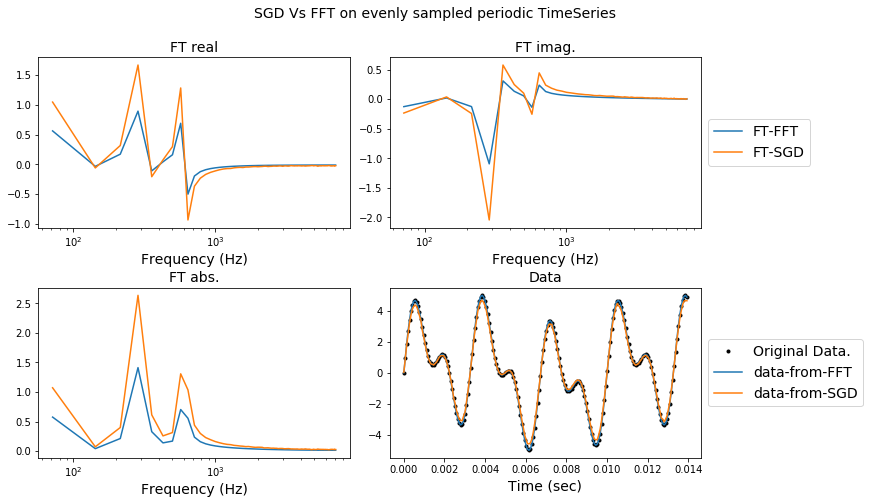

In [3]:
# constants
basic_dt = 0.00007
f_max = 1/(2*basic_dt) / 2
gamma = 1

# variables
times = TimesSamples(n=N, delta=basic_dt, struct="normal")
data = TimeSeries(periodic_data([1, 3, 2], [100, 300, 600], times), times=times)
freqs = np.fft.fftfreq(N, d=basic_dt)[1:N//2]
freqs = FrequencySamples(initial_array=freqs)  # same freq for both methods

# transform
ft_fft = np.fft.fft(data.value)[1:N//2]/N
reg.reset()
reg.create_dict(times, freqs)
ft_lr = data.to_frequencyseries(reg=reg)

# reconstruct
data_fft = np.real(np.fft.ifft(np.fft.fft(data.value)))
data_sgd = reg.predict()

plot_freqs(data, times, [times, times], [ft_fft, ft_lr], [freqs, freqs], [data_fft, data_sgd],
          xaxis=["Frequency (Hz)", "Frequency (Hz)", "Frequency (Hz)", "Time (sec)"],
          main_title="SGD Vs FFT on evenly sampled periodic TimeSeries")

#### Linear Regressor Vs FFT on evenly time sampled and non periodic signal

Score for [FFT, Regressor]:  [1.0, 0.9842788363244379]


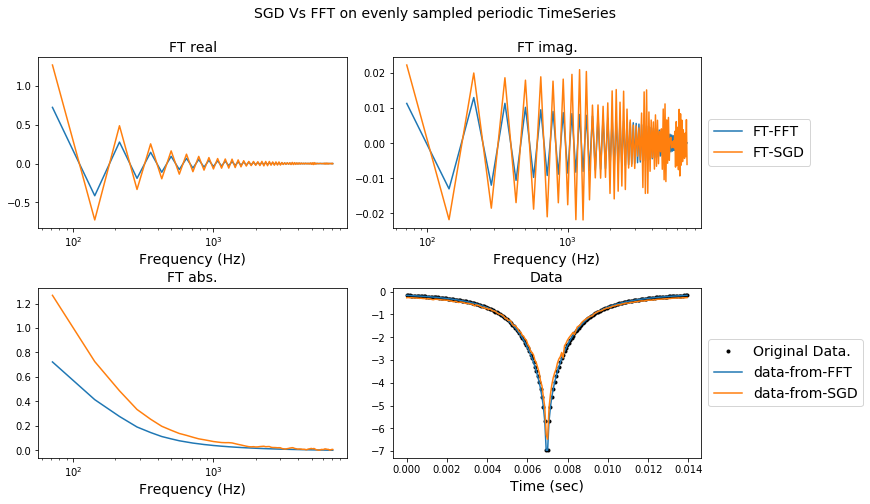

In [4]:
# constants
basic_dt = 0.00007
f_max = 1/(2*basic_dt) / 2
gamma = 1

# variables (U0, t0, tE, fs, times)
times = TimesSamples(n=N, delta=basic_dt, struct="normal")
data = TimeSeries(micro_lens(0.00003, times.duration/2, 0.0008, 24, times), times=times)
freqs = np.fft.fftfreq(N, d=basic_dt)[1:N//2]
freqs = FrequencySamples(initial_array=freqs)  # same freq for both methods

# transform
ft_fft = np.fft.fft(data.value)[1:N//2]/N
reg.reset()
reg.create_dict(times, freqs)
ft_lr = data.to_frequencyseries(reg=reg)

# reconstruct
data_fft = np.real(np.fft.ifft(np.fft.fft(data.value)))
data_sgd = reg.predict()

plot_freqs(data, times, [times, times], [ft_fft, ft_lr], [freqs, freqs], [data_fft, data_sgd],
          xaxis=["Frequency (Hz)", "Frequency (Hz)", "Frequency (Hz)", "Time (sec)"],
          main_title="SGD Vs FFT on evenly sampled periodic TimeSeries")

print("Score for [FFT, Regressor]: " ,scores([data, data], [data_fft, data_sgd]))

#### Linear Regressor Vs FFT on unevenly time sampled non periodic TimeSeries with small gaps
These are just small irregularities

Score for [FFT, Regressor]:  [0.9998452012571781, 0.9728937019270714]


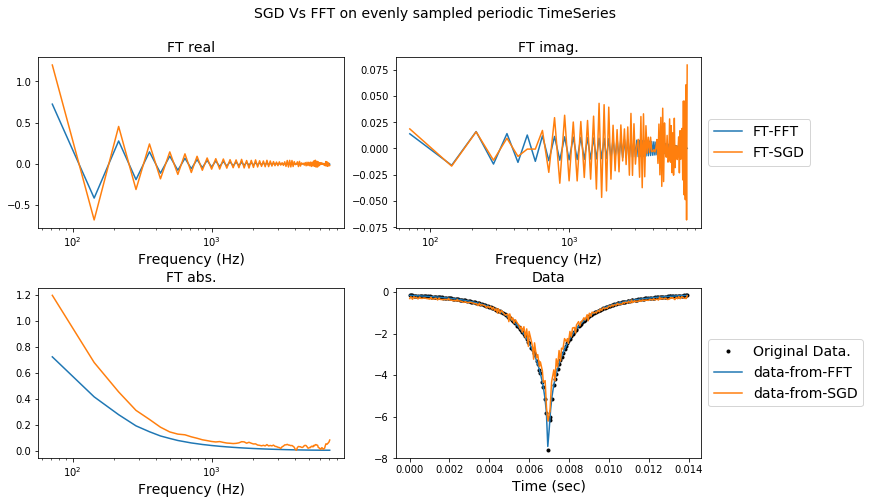

In [5]:
# constants
basic_dt = 0.00007
f_max = 1/(2*basic_dt) / 2
gamma = 1

# variables (U0, t0, tE, fs, times)
epsilon = np.random.normal(0, basic_dt * 0.2, N)
uneve_times = TimesSamples(n=N, delta=basic_dt, struct="slight", epsilon=epsilon)
eve_times = np.linspace(uneve_times.min(), uneve_times.max(), N)
eve_times = TimesSamples(initial_array=eve_times, delta=eve_times[1]-eve_times[0])

uneve_data = TimeSeries(micro_lens(0.00003, uneve_times.duration/2, 0.0008, 24, uneve_times), times=uneve_times)
eve_data = TimeSeries(np.interp(eve_times, uneve_times, uneve_data), times=eve_times)
ref_data = TimeSeries(micro_lens(0.00003, uneve_times.duration/2, 0.0008, 24, eve_times), times=eve_times)

freqs = np.fft.fftfreq(N, d=basic_dt)[1:N//2]
freqs = FrequencySamples(initial_array=freqs)  # same freq for both methods

# transform
eve_ft_fft = np.fft.fft(eve_data.value)[1:N//2]/N
ref_ft_fft = np.fft.fft(ref_data.value)[1:N//2]/N
reg.reset()
reg.create_dict(uneve_times, freqs)
ft_lr = uneve_data.to_frequencyseries(reg=reg)

# reconstruct
eve_data_fft = np.real(np.fft.ifft(np.fft.fft(eve_data.value)))
ref_data_fft = np.real(np.fft.ifft(np.fft.fft(ref_data.value)))
data_sgd = reg.predict()

plot_freqs(uneve_data, uneve_times, [eve_times, uneve_times],
           [eve_ft_fft, ft_lr], [freqs, freqs], [eve_data_fft, data_sgd],
          xaxis=["Frequency (Hz)", "Frequency (Hz)", "Frequency (Hz)", "Time (sec)"],
          main_title="SGD Vs FFT on evenly sampled periodic TimeSeries")

print("Score for [FFT, Regressor]: " ,scores([ref_data, uneve_data], [eve_data_fft, data_sgd]))

#### Linear Regressor Vs FFT on unevenly time sampled non periodic TimeSeries with big gaps
Gap between the peak of the signal

Score for [FFT, Regressor]:  [0.9222439432550423, 0.9969902802655723]


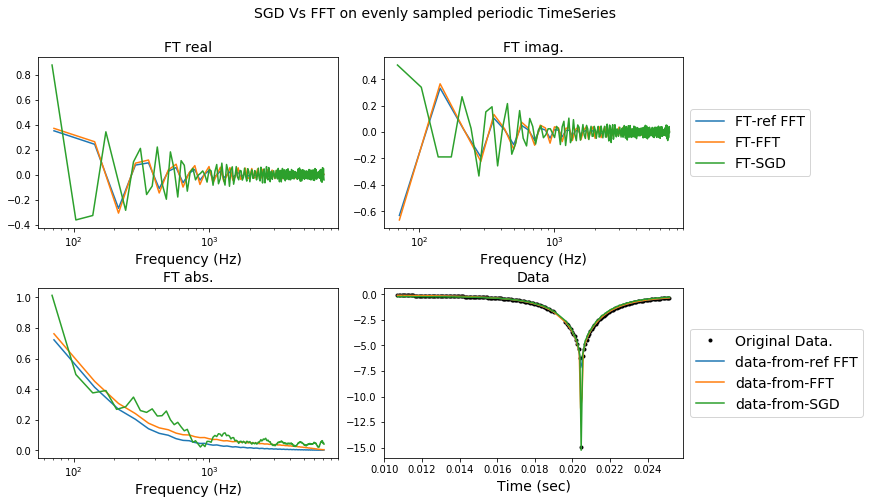

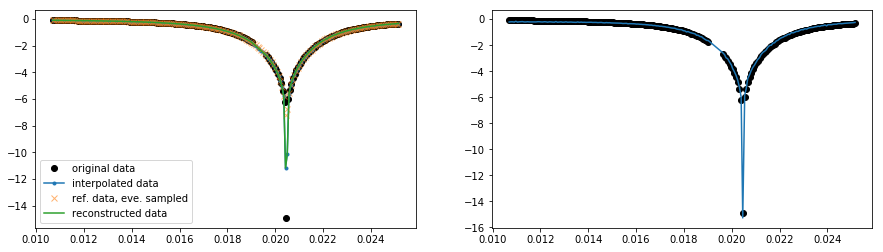

In [6]:
# constants
basic_dt = 0.00007
f_max = 1/(2*basic_dt) / 2
gamma = 2

# variables (U0, t0, tE, fs, times)
epsilon = np.random.normal(0, basic_dt * 0.2, N)
uneve_times = TimesSamples(n=N, delta=basic_dt, struct="automix", epsilon=epsilon)
eve_times = np.linspace(uneve_times.min(), uneve_times.max(), N)
eve_times = TimesSamples(initial_array=eve_times, delta=eve_times[1]-eve_times[0])
t0 = np.random.choice(uneve_times[10:N-10])
uneve_data = TimeSeries(micro_lens(0.00003, t0, 0.0008, 24, uneve_times), times=uneve_times)
eve_data = TimeSeries(np.interp(eve_times, uneve_times, uneve_data), times=eve_times)
ref_data = TimeSeries(micro_lens(0.00003, t0, 0.0008, 24, eve_times), times=eve_times)

eve_freqs = np.fft.fftfreq(N, d=basic_dt)[1:N//2]
uneve_freqs = f_grid(uneve_times, gamma=gamma, f_max=max(eve_freqs))  # different freqs

# transform
eve_ft_fft = np.fft.fft(eve_data.value)[1:N//2]/N
ref_ft_fft = np.fft.fft(ref_data.value)[1:N//2]/N
reg.reset()
reg.create_dict(uneve_times, uneve_freqs)
ft_lr = uneve_data.to_frequencyseries(reg=reg)

# reconstruct
ref_data_fft = np.real(np.fft.ifft(np.fft.fft(ref_data.value)))
eve_data_fft = np.real(np.fft.ifft(np.fft.fft(eve_data.value)))
data_sgd = reg.predict()

plot_freqs(uneve_data, uneve_times, [eve_times, eve_times, uneve_times],
           [ref_ft_fft, eve_ft_fft, ft_lr], 
           [eve_freqs, eve_freqs, uneve_freqs], [ref_data_fft, eve_data_fft, data_sgd],
           labels=["ref FFT", "FFT", "SGD"],
           xaxis=["Frequency (Hz)", "Frequency (Hz)", "Frequency (Hz)", "Time (sec)"],
           main_title="SGD Vs FFT on evenly sampled periodic TimeSeries")

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot(uneve_times, uneve_data, "ko", label="original data")
ax1.plot(eve_times, eve_data, ".-", label="interpolated data")
ax1.plot(eve_times, ref_data, "x", alpha=0.6, label="ref. data, eve. sampled")
ax1.plot(eve_times, eve_data_fft, label="reconstructed data")
ax1.legend()
ax2.plot(uneve_times, uneve_data, "ko", label="original data")
ax2.plot(uneve_times, data_sgd, label="reconstructed data")
print("Score for [FFT, Regressor]: " ,scores([ref_data, uneve_data], [eve_data_fft, data_sgd]))

#### Linear Regressor Vs FFT on real unevenly sampled TimeSeries

We use a micro-lens from MACHO data set

In [17]:
# read file
def read_file():
     # folder MLensing with the files should be placed out 
     # of the root file of the project (the one with the .git)
    return glob.glob("../../../MLensing/*.mjd")

def read_data(files, j, ini, end, prints=False):
    a = pd.read_csv(files[j], skiprows=3, header=None, sep=" ") # read the table
    a.columns = ["MJD", "Mag", "err"] # name the columns
    times = TimesSamples(a["MJD"][ini:end]) # read the times in MJD
    times -= times.min() # normalize to 0, this give us units of days
    times *= days_to_sec # transform to units of seconds
    if prints:
        print("after normalize, we get an average sampling rate of:", 
              times.average_fs, "samples per seconds")
    times *= times.average_fs # normalize to units of samples (for digital signals)
    if prints:
        print("after normalize, we get an average sampling rate of:", times.average_fs, 
              "samples per cycles \n with this, perfect reconstruction is guaranteed " +
              "possible for a bandlimit of: ", times.average_fs/2)
    data = TimeSeries(a["Mag"][ini:end], times=times) # get the magnitude
    data -= np.median(data) # normalize the magnitud to 0 (the center goes to 0).
    err =  a["err"].tolist()[ini:end] # get the error
    return times, data, err



# define constants
j = 15 # the particular observation to use, j={5, 9, 14} gives bad results 
ini = 0 # init of a range of the observations, we use the whole data
end = -1 # end of a range of the observation, we use the whole data
days_to_sec = 1 * 24 * 60 * 60 # transformation from days to seconds
sec_to_days = 1 /(60 * 60 * 24) # transformation from seconds to days


after normalize, we get an average sampling rate of: 3.087907321466325e-06 samples per seconds
after normalize, we get an average sampling rate of: 1.0 samples per cycles 
 with this, perfect reconstruction is guaranteed possible for a bandlimit of:  0.5

due to too big errors, the number of data was reduced from 442 to 429


/home/astro/.local/lib/python3.6/site-packages/numpy/core/_methods.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/home/astro/.local/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Mag')

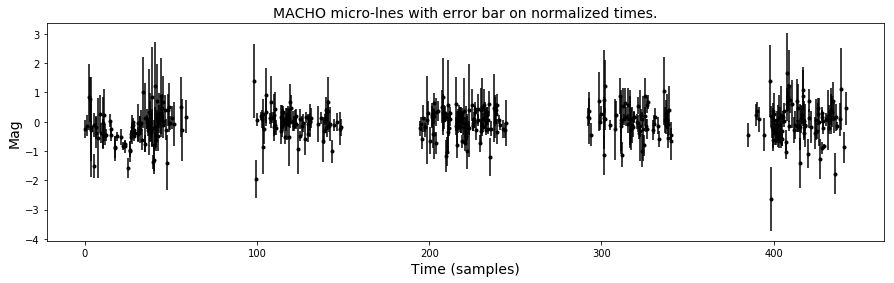

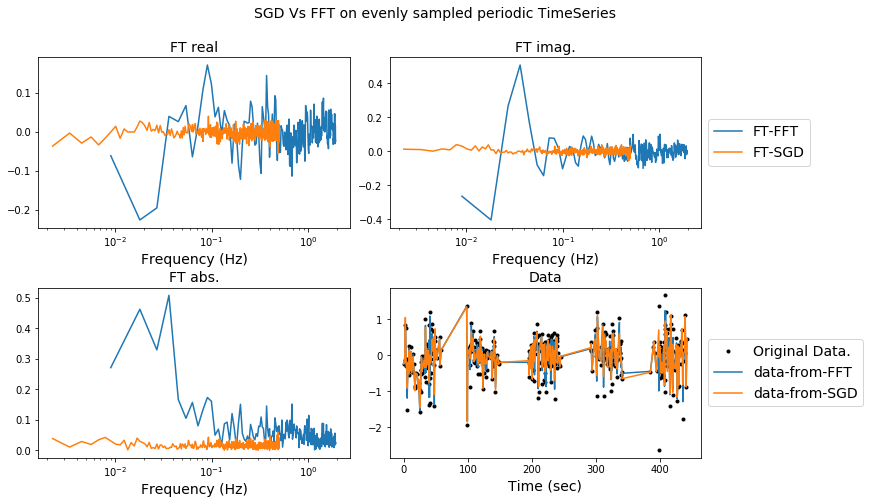

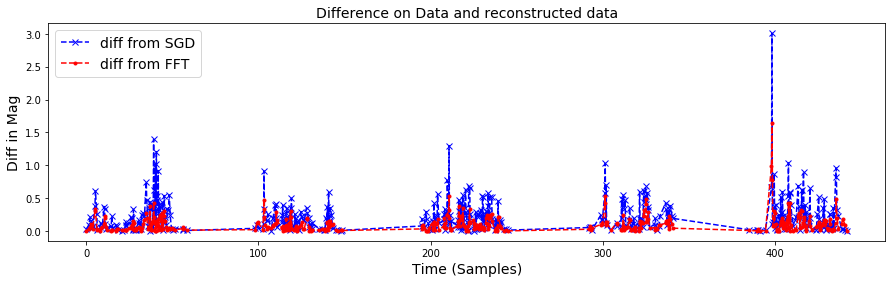

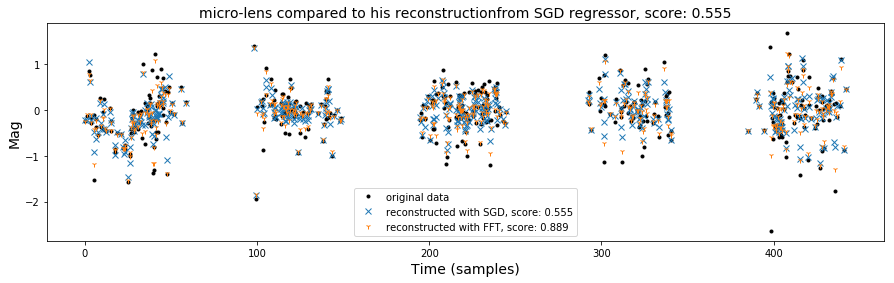

In [18]:
# variables
files = read_file()
times, data, err = read_data(files, j, ini, end, prints=True)
gamma = 2
f_max = 0.5
N = len(times)

# erase data with too big errorba
max_w = np.abs(data.max() - data.min())
i=0
while i < len(times)-1:
    if err[i] > max_w/3:
        times.delete(slice(i, i+1))
        data.delete(slice(i, i+1))
        err = np.delete(err, slice(i, i+1))
    else:
        i+=1
print("")
print("due to too big errors, the number of data was reduced from {} to {}".format(N, len(times)))
plt.figure(figsize=(15, 4))
plt.errorbar(times, data, yerr=err, fmt=".", color="k")
plt.title("MACHO micro-lnes with error bar on normalized times.", fontsize=14)
plt.xlabel("Time (samples)", fontsize=14)
plt.ylabel("Mag", fontsize=14)

N = len(times) # update N

# interpolate times and data, use simple interpolation
eve_times = TimesSamples(initial_array=np.linspace(times.min(), times.max(), 4*N))
eve_data = TimeSeries(np.interp(eve_times, times, data), times=eve_times)


# create the frequency grid
freqs = f_grid(times, gamma=gamma, f_max=f_max)
eve_freqs = np.fft.fftfreq(N, d=1/eve_times.average_fs)[1:N//2]
#create dictionary on regressor instance
reg = SGDRegression(alpha=10**(-4), max_iter=500, penalty="l1", l1_ratio=0.5, tol=0.001)
reg.reset() # we reset a previous instance
reg.create_dict(times, freqs) # set dictionary

# transform
ft_sgd = data.to_frequencyseries(reg=reg) # inverse transform
ft_fft = np.fft.fft(eve_data)[1:N//2]/N
data_sgd = reg.predict() # direct transform
data_fft = np.fft.ifft(np.fft.fft(eve_data))
uneve_data_fft = TimeSeries(np.interp(times, eve_times, data_fft), times=times)
scor = scores([data, data], [data_sgd, uneve_data_fft])
plot_freqs(data, times, [times, times],
           [ft_fft, ft_sgd], [eve_freqs, freqs], [uneve_data_fft, data_sgd],
          xaxis=["Frequency (Hz)", "Frequency (Hz)", "Frequency (Hz)", "Time (sec)"],
          main_title="SGD Vs FFT on evenly sampled periodic TimeSeries")

# plot diff between orig-reconstructed
diff1 = np.abs(data - data_sgd)
diff2 = np.abs(data - np.real(uneve_data_fft))
plt.figure(figsize=(15, 4))
plt.plot(times, diff1, "bx--", label="diff from SGD")
plt.plot(times, diff2, "r.--", label="diff from FFT")
plt.legend(fontsize=14)
plt.title("Difference on Data and reconstructed data", fontsize=14)
plt.xlabel("Time (Samples)", fontsize=14)
plt.ylabel("Diff in Mag", fontsize=14)
plt.figure(figsize=(15, 4))
plt.plot(times, data, 'k.', label="original data")
plt.plot(times, data_sgd, 'x', label="reconstructed with SGD, score: {}".format(round(scor[0], 3)))
plt.plot(times, np.real(uneve_data_fft), '1', label="reconstructed with FFT, score: {}".format(round(scor[1], 3)))
plt.legend()
plt.title("micro-lens compared to his reconstruction" + 
          "from SGD regressor, score: {}".format(round(scores([data], [data_sgd])[0], 3)), fontsize=14)
plt.xlabel("Time (samples)", fontsize=14)
plt.ylabel("Mag", fontsize=14)